In [1]:
!git clone https://github.com/kremenevskiy/testImageNet.git

Cloning into 'testImageNet'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 21 (delta 9), reused 18 (delta 6), pack-reused 0
Unpacking objects: 100% (21/21), 4.62 KiB | 525.00 KiB/s, done.


In [2]:
!cp testImageNet/* ./
!sh run.sh

Installing requirements...
  Preparing metadata (setup.py) ... - done
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1321 sha256=2f2ea4e59371fd5b1a37268a576cb449ee138da7add9597fceb841220c9122b9
  Stored in directory: /root/.cache/pip/wheels/c5/05/b3/f7b36dbaaf76de31b718cde792c953bfd11d2414a72f204b56
Successfully built unzip
--2022-01-26 19:34:58--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  78.7MB/s    in 3.0s    

2022-01-26 19:35:01 (78.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

Unzipping Tiny ImageNet...
Divide Validation folder to Validation / test (50/50) ...
Copying all images to ./tiny-224...
Resiz

In [3]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from train_model import train_model
from test_model import test_model

In [4]:
data_dir = 'tiny-224'
num_workers = {'train': 8, 'val': 0, 'test': 0}

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                    for x in ['train', 'val', 'test']}

data_loaders = {x: data.DataLoader(image_datasets[x], batch_size=100, shuffle=True, num_workers=num_workers[x])
                   for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x])
                    for x in ['train', 'val', 'test']}

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
model = models.resnet18(True)

# FineTune it
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc.out_features = 200
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss
criterion = nn.CrossEntropyLoss()
optimazer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

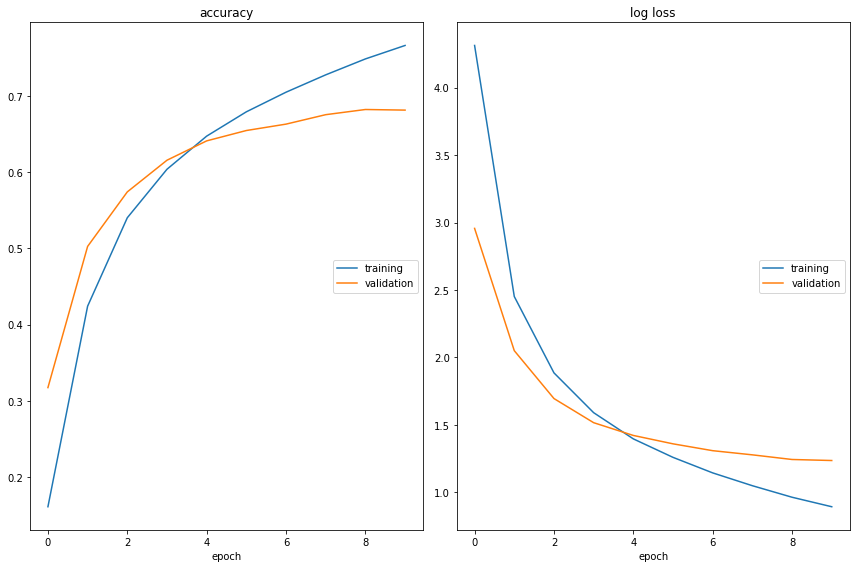

accuracy
	training         	 (min:    0.161, max:    0.766, cur:    0.766)
	validation       	 (min:    0.317, max:    0.682, cur:    0.682)
log loss
	training         	 (min:    0.894, max:    4.312, cur:    0.894)
	validation       	 (min:    1.236, max:    2.957, cur:    1.236)
Train Loss: 0.8940 Acc: 0.7665
Val Loss: 1.2365 Acc: 0.6816

Training complete in 45m 19s
Best Validation Accuracy: 0.6824, Epoch: 9


In [6]:
# Train model 
num_epochs = 10
train_model(output_path='224', model=model, dataloaders=data_loaders, dataset_sizes=dataset_sizes,
               criterion=criterion, optimizer=optimazer, num_epochs=num_epochs)

In [7]:
import shutil
shutil.make_archive('model', 'zip', './models')

'/kaggle/working/model.zip'

In [8]:
!du -sh /kaggle/working/models

447M	/kaggle/working/models
